## Looking at known heterozygous loci in my sample and looking at the VAF per read group (meaning same start/stop position).

In [49]:
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import os.path as path
import seaborn as sns
import vcf
mpl.rcParams['figure.dpi']= 300

In [105]:
sample_names = {
"hybr4_S8":"FFPE_3ng_A_1",
"hybr2_S6":"FFPE_3ng_S",
"hybr5_S10":"FFPE_3ng_B_1",}

## Read in heterozygous SNPs from fresh frozen match of the FFPE samples

In [16]:
vcf_reader = vcf.Reader(filename='../data/DI/FRFZ-vardict-germline.filter.vcf.gz')
hets = []

for record in vcf_reader:
    hets.append(('chr' + str(record.CHROM),record.POS))

het_df=pd.DataFrame(hets,columns=['chr','pos'])

## Plot the VAF for each heterozygous SNP per read group

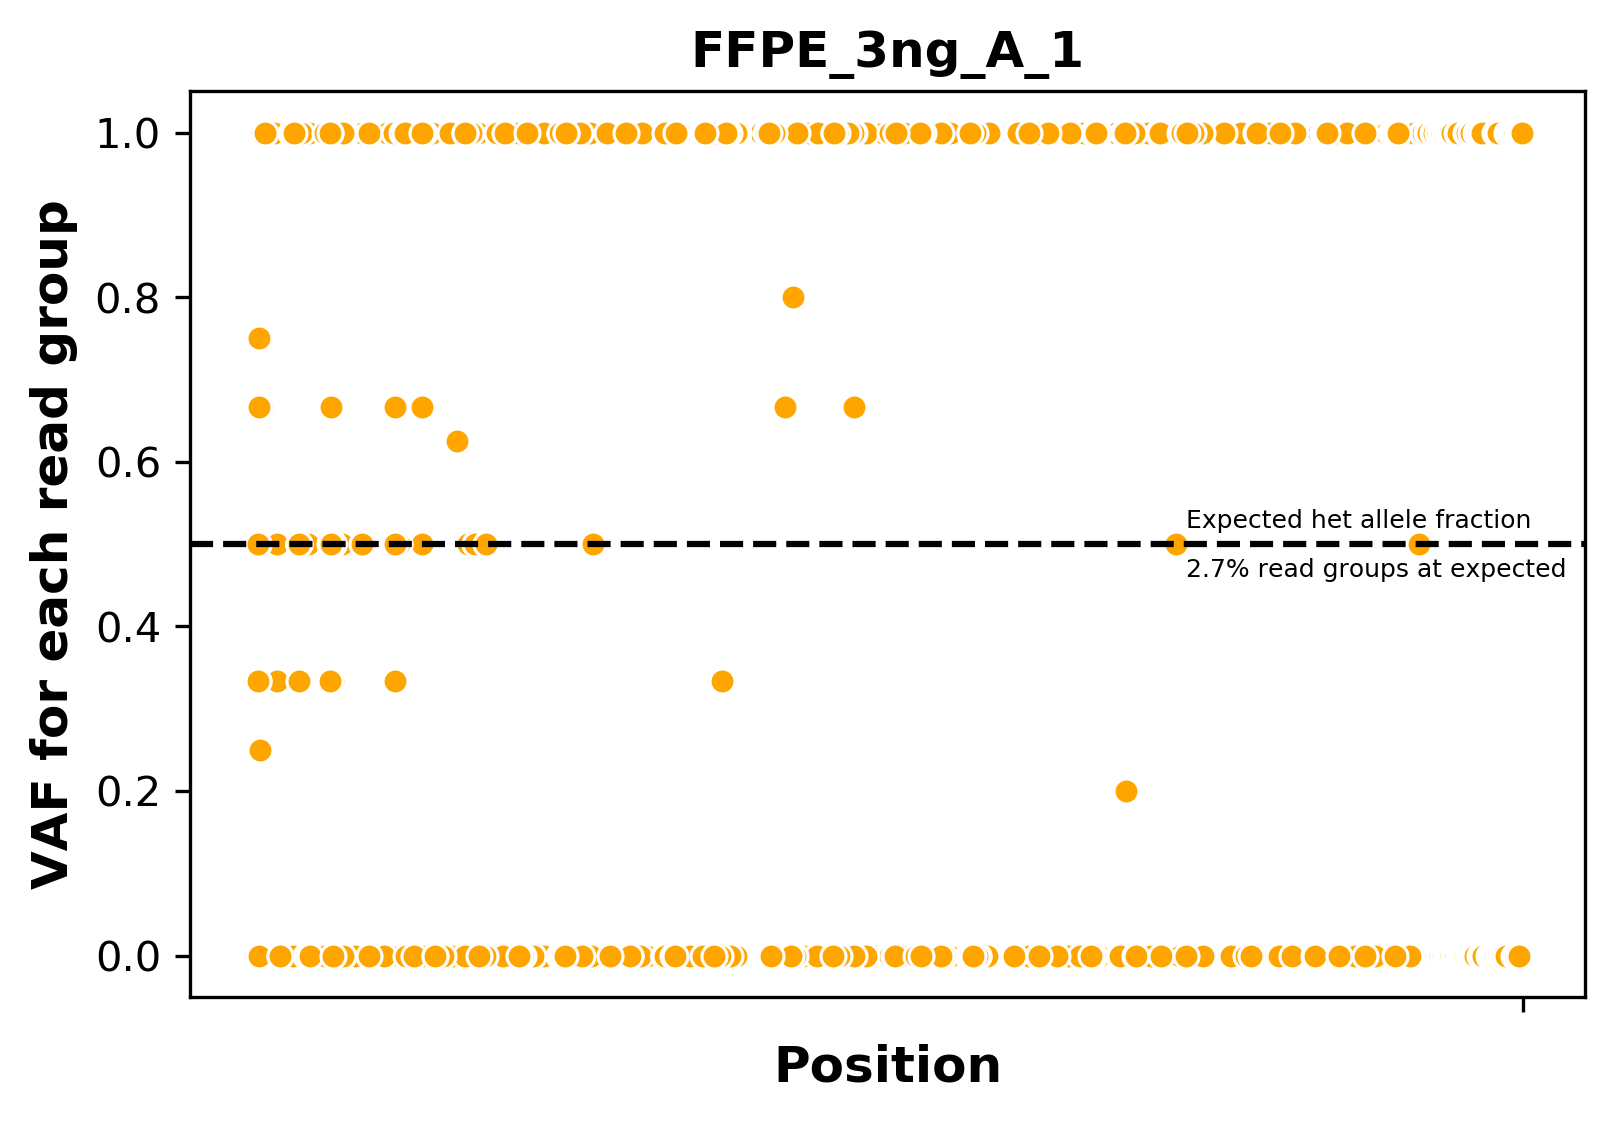

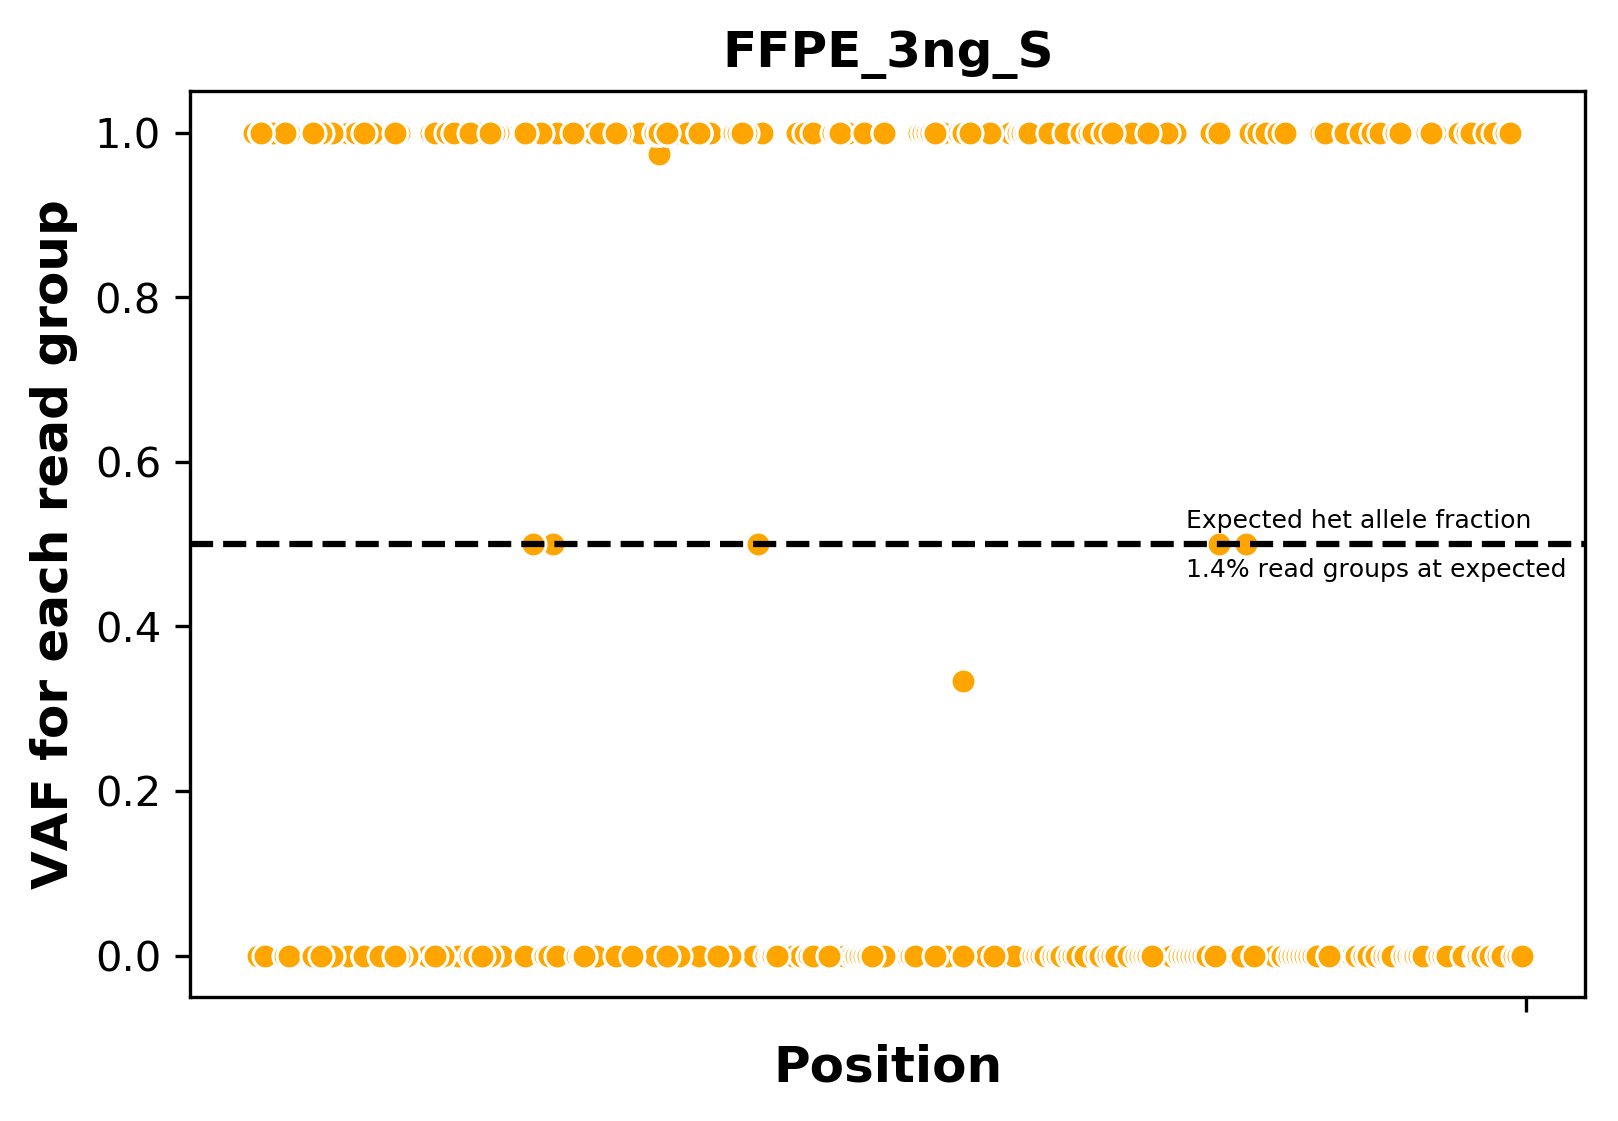

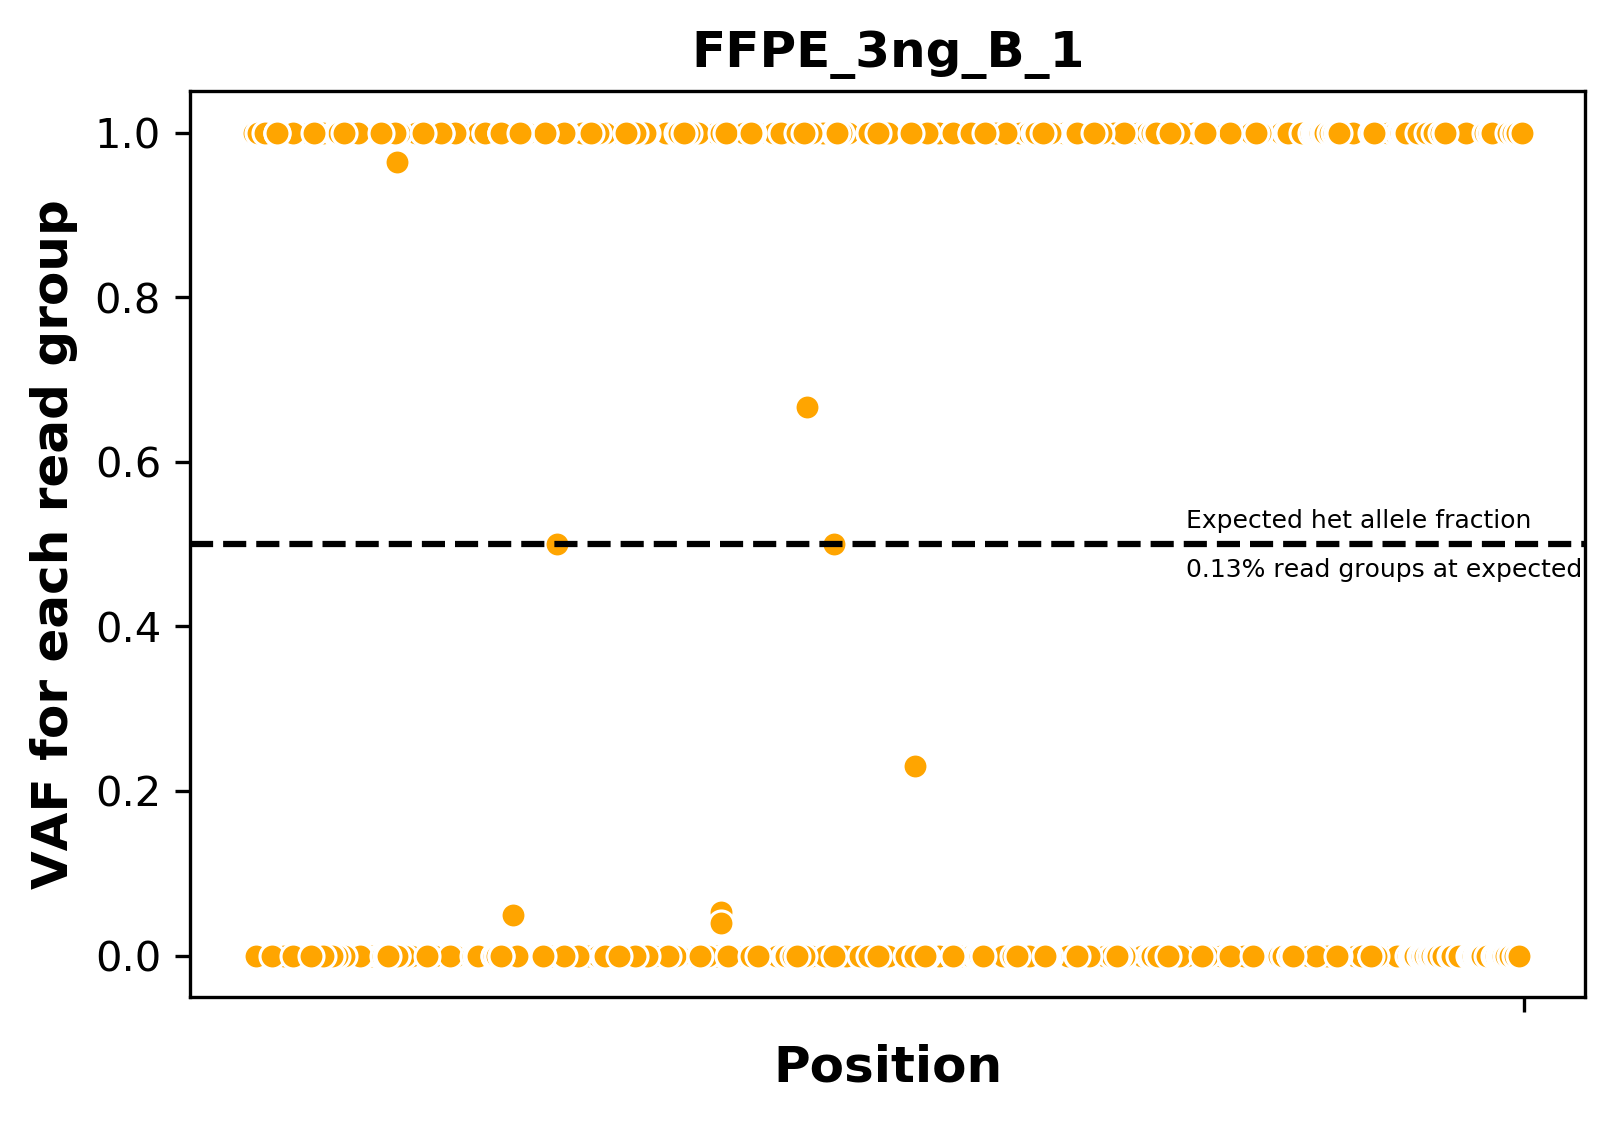

In [108]:
for sample in sample_names.keys():    
    
    afs = []
    chrs = []
    poss = []
    
    for filename in glob.iglob('../data/DI/{}.*.pileup.txt'.format(sample)):
        df = pd.read_table(filename,names=['chr','pos','ref','depth','reads','quals'])
        df = df[df['depth'] > 0]
        df['reads_u'] = df['reads'].str.upper()
        df['alt_count'] = df['reads_u'].str.count('[ACGT]')
        df['af'] = df['alt_count'] / df['depth']
        df['af_adj'] = [max(i, 1.0-i) for i in df['af']]
        afs.extend(df['af'])
        chrs.extend(df['chr'])
        poss.extend(df['pos'])
    
    data = pd.DataFrame(columns=['chr','pos','af'])
    data['chr'] = chrs
    data['pos'] = poss
    data['af'] = afs
    data = data[data['af'] <= 1.0]
    data = data[data['pos'].isin(het_df['pos'])] 

    ax = sns.scatterplot(x=data['pos'].astype(str),
                         y=data['af'],
                         color='orange')
    
    frac_at_expected = (data[(data['af'] >0.4) & (data['af']<0.6) ]).shape[0]/data.shape[0]*100 

    ax.set_xlabel('Position',fontsize=12,fontweight='bold')
    ax.set_ylabel('VAF for each read group',fontsize=12,fontweight='bold')
    ax.set_title('{}'.format(sample_names[sample]),fontsize=12,fontweight='bold')
    ax.axhline(y=0.5,color='k',linestyle='--')
    ax.set_xticks('')
    ax.text(ax.get_xlim()[1]*0.7,0.52,'Expected het allele fraction',fontsize=6)
    ax.text(ax.get_xlim()[1]*0.7,0.46,'{0:.2g}% read groups at expected'.format(frac_at_expected),fontsize=6)
    plt.show()